In [1]:
import pandas as pd
import glob
import os
import requests
import pandas as pd
from pyproj import Transformer
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Join and Drop

In [ ]:
# Define los prefijos de los archivos a buscar
prefixes = ["APOYOS", "EVENTOS", "REDMT", "SWITCHES",
            "TRAFOS","VegetacionExistente","Rayos","NODOS_ELECTRICOS","NODOS ENERGIA"]

# Diccionario con las columnas a eliminar por cada prefijo
columnas_a_eliminar = {
    'APOYOS': ['DESCRIPTIO', 'ADDRESS', 'PROJECT', 'USER_', 'PICTURE', 'SYMBOL',
               'METERCODE', 'CUSTOMERS', 'CUSTOMER_0', 'CUSTOMER_1', 'CUSTOMER_2',
               'DATUM', 'XSIZE', 'YSIZE', 'X', 'Y', 'STATE', 'MATERIAL', 'RESISTMECH',
                'CODEBDE', 'POBLACION', 'INVNUMBER', 'LONGITUD',
               'LATITUD', 'FECHA_COPIA', 'FID', 'IUA', 'DATE_INST','CLASS','HEIGHT','COUNTY','ZONE','OWNER','Z'],
    'REDMT': ['DESCRIPTIO', 'ADDRESS', 'PROJECT', 'ASSEMBLY', 'USER_', 'PICTURE', 'SYMBOL',
              'METERCODE', 'CUSTOMERS', 'CUSTOMER_0', 'CUSTOMER_1', 'CUSTOMER_2', 'DATUM',
              'XSIZE', 'YSIZE', 'IEQUIPMENT', 'IEQUIPTYPE', 'FEQUIPMENT', 'FEQUIPTYPE',
               'SPAN', 'STATE', 'SEQUENCE', 'RTHEV', 'XTHEV', 'R0THEV', 'X0THEV',
              'CODEBDE', 'LENGTHBDE', 'POBLACION', 'INVNUMBER', 'PRCREG097',
              'FECHA_COPIA', 'FID', 'IUA','GUARDA','R','G','B'],
    'SWITCHES': ['DESCRIPTIO', 'ADDRESS', 'PROJECT', 'USER_', 'PICTURE', 'SYMBOL',
                 'METERCODE', 'CUSTOMERS', 'CUSTOMER_0', 'CUSTOMER_1', 'CUSTOMER_2', 'TPARENT',
                 'DATUM', 'XSIZE', 'YSIZE', 'TYPE', 'FPARENT1', 'FPARENT2', 'UC',
                 'LATITUD', 'LONGITUD', 'FECHA_COPIA', 'FID', 'IUA','AMP'],
    'TRAFOS': ['DESCRIPTIO', 'ADDRESS', 'PROJECT', 'ASSEMBLY', 'USER_', 'PICTURE', 'SYMBOL',
               'METERCODE', 'CUSTOMERS', 'CUSTOMER_0', 'CUSTOMER_1', 'CUSTOMER_2', 'INVNUMBER',
               'DATUM', 'ISON', 'FLAG', 'LVELNODE', 'PHNODE', 'MVA3PH_SCC', 'MVA1PH_SCC',
               'CULOSSES', 'FELOSSES', 'GROUP_', 'CODEBANK', 'ISOPEN', 'TYPE', 'TIPO_RED', 'SERIAL',
               'POBLACION', 'IS_BANK', 'NUM_TRFS', 'ENEG', 'LATITUD', 'LONGITUD', 'FECHA_COPIA',
               'ZONE', 'GRUPO', 'TIPOFUSES', 'ZONAE', 'CONNECT_', 'PCV', 'ISLIGHT',
               'ISLIGHT2', 'FID', 'IUA','XSIZE', 'YSIZE','MUNICIPIO','DPTO','OWNER','OWNERNAME','Z','R','G','B','CASO'],
    "VegetacionExistente": [],
    "Rayos": [],
    "NODOS_ELECTRICOS": [],
    "NODOS ENERGIA": []
    }

def verificar_y_unir_archivos(prefix, path, output_path):
    # Busca todos los archivos que empiezan con el prefijo especificado
    archivos = glob.glob(f'{path}{prefix}*.csv')
    if not archivos:
        print(f"No se encontraron archivos para el prefijo: {prefix}")
        return

    # Si solo hay un archivo, devolverlo tal cual después de eliminar duplicados
    if len(archivos) == 1:
        print(f"Solo un archivo encontrado para el prefijo {prefix}, se mantendrá: {os.path.basename(archivos[0])}")
        df = pd.read_csv(archivos[0], sep=';', low_memory=False)
        filas_antes = df.shape[0]
        df = df.drop_duplicates()

        # Elimina las columnas específicas si existen en el DataFrame
        columnas_a_eliminar_prefijo = columnas_a_eliminar.get(prefix, [])
        df = df.drop(columns=[col for col in columnas_a_eliminar_prefijo if col in df.columns], errors='ignore')

        filas_despues = df.shape[0]
        df.to_csv(os.path.join(output_path, f'{prefix}.csv'), index=False)
        print(f"{prefix}: Filas antes de eliminar duplicados: {filas_antes}, Filas después: {filas_despues}")
        return

    # Lee el primer archivo para obtener las columnas de referencia
    columnas_referencia = pd.read_csv(archivos[0], sep=';', low_memory=False).columns
    print(f"Verificando y uniendo columnas para archivos con prefijo: {prefix}")

    # Lista para almacenar DataFrames con columnas coincidentes
    dataframes = []

    # Añadir el primer archivo al DataFrame
    dataframes.append(pd.read_csv(archivos[0], sep=';', low_memory=False))

    # Compara las columnas de los demás archivos con las columnas de referencia y los une si coinciden
    for archivo in archivos[1:]:
        columnas_actuales = pd.read_csv(archivo, sep=';', low_memory=False).columns
        if not columnas_referencia.equals(columnas_actuales):
            print(f"Las columnas no coinciden en el archivo: {os.path.basename(archivo)}")
            print(f"Columnas de referencia: {list(columnas_referencia)}")
            print(f"Columnas actuales: {list(columnas_actuales)}")
        else:
            print(f"Las columnas coinciden en el archivo: {os.path.basename(archivo)}. Se añadirá a la unión.")
            dataframes.append(pd.read_csv(archivo, sep=';', low_memory=False))

    # Unir todos los DataFrames con columnas coincidentes
    if dataframes:
        df_final = pd.concat(dataframes, ignore_index=True)
        filas_antes = df_final.shape[0]
        df_final = df_final.drop_duplicates()

        # Elimina las columnas específicas si existen en el DataFrame
        columnas_a_eliminar_prefijo = columnas_a_eliminar.get(prefix, [])
        df_final = df_final.drop(columns=[col for col in columnas_a_eliminar_prefijo if col in df_final.columns], errors='ignore')

        filas_despues = df_final.shape[0]

        # Guardar el archivo combinado con el nombre del prefijo
        output_file = os.path.join(output_path, f'{prefix}.csv')
        df_final.to_csv(output_file, index=False)
        print(f"{prefix}: Archivos combinados guardados como: {output_file}")
        print(f"{prefix}: Filas antes de eliminar duplicados: {filas_antes}, Filas después: {filas_despues}")
    else:
        print(f"No se pudo combinar archivos para el prefijo: {prefix}")

# Define el path de entrada y salida
path = '/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/'
output_path = '/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'

# Asegúrate de que la carpeta de salida existe
os.makedirs(output_path, exist_ok=True)

# Itera sobre cada prefijo y verifica y une los archivos
for prefix in prefixes:
    verificar_y_unir_archivos(prefix, path, output_path)

Verificando y uniendo columnas para archivos con prefijo: APOYOS
Las columnas coinciden en el archivo: APOYOS_2020.csv. Se añadirá a la unión.
Las columnas coinciden en el archivo: APOYOS_2021.csv. Se añadirá a la unión.
Las columnas coinciden en el archivo: APOYOS_2022.csv. Se añadirá a la unión.
Las columnas coinciden en el archivo: APOYOS_2023_2024.csv. Se añadirá a la unión.
APOYOS: Archivos combinados guardados como: /content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/APOYOS.csv
APOYOS: Filas antes de eliminar duplicados: 4153822, Filas después: 4153822
Solo un archivo encontrado para el prefijo EVENTOS, se mantendrá: EVENTOS_2019_2024.csv
EVENTOS: Filas antes de eliminar duplicados: 189639, Filas después: 189639
Verificando y uniendo columnas para archivos con prefijo: REDMT
Las columnas coinciden en el archivo: REDMT_2023.csv. Se añadirá a la unión.
Las columnas coinciden en el archivo: REDMT_2024.csv. Se añadirá a la unión.
Las columnas coinciden en el archivo

# Ubicación


In [2]:
import pandas as pd
import glob
import os
# Define los prefijos de los archivos a buscar
prefixes = ["APOYOS", "EVENTOS", "REDMT", "SWITCHES",
            "TRAFOS","VegetacionExistente","Rayos","NODOS ENERGIA"]
def crear_excel_resumen(output_path,prefixes, output_excel):
    with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
        for prefix in prefixes:
            df =pd.read_csv(output_path+prefix+'.csv')
            # Crear resumen de las columnas con tipo de dato y porcentaje de valores nulos
            resumen = pd.DataFrame({
                'Columna': df.columns,
                'Tipo de Dato': [str(df[col].dtype) for col in df.columns],
                'Porcentaje de Vacíos': [(df[col].isnull().mean() * 100) for col in df.columns]
            })
            # Escribir el resumen en una hoja con el nombre del prefijo
            resumen.to_excel(writer, sheet_name=prefix, index=False)
            print(f"Resumen creado para {prefix}")
# Define el path de entrada y salida
path = '/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
output_path = '/content/drive/Shareddrives/CHEC/data_chec/datos/Data_Total/'
output_excel = os.path.join(output_path, 'Resumen_Inicial.xlsx')
# Crear el archivo Excel con el resumen de columnas para cada prefijo
crear_excel_resumen(path ,prefixes, output_excel)
print(f"Archivo Excel de resumen guardado en: {output_excel}")

Resumen creado para APOYOS
Resumen creado para EVENTOS
Resumen creado para REDMT
Resumen creado para SWITCHES
Resumen creado para TRAFOS


<ipython-input-2-8c27d34c51ec>:10: DtypeWarning: Columns (1,7,29,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df =pd.read_csv(output_path+prefix+'.csv')


Resumen creado para VegetacionExistente


<ipython-input-2-8c27d34c51ec>:10: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df =pd.read_csv(output_path+prefix+'.csv')


Resumen creado para Rayos
Resumen creado para NODOS ENERGIA
Archivo Excel de resumen guardado en: /content/drive/Shareddrives/CHEC/data_chec/datos/Data_Total/Resumen_Inicial.xlsx


In [3]:
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np

# Supongamos que df es tu DataFrame original con columnas 'LATITUD' y 'LONGITUD'
# y a es el DataFrame con la información de referencia que incluye 'Latitud', 'Longitud', 'Nombre Departamento', 'Nombre Municipio'

# Ejemplo de DataFrame original
# Convertir las coordenadas a un array para crear el árbol KD
m=pd.read_excel('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/8. Clasificador Geográfico.xlsx')
m=m[m['Nombre Departamento'].isin(['CALDAS','RISARALDA','QUINDÍO'])]
m=m[['Nombre Departamento','Nombre Municipio','Longitud','Latitud']]
# Reemplazar comas por puntos en las columnas 'Latitud' y 'Longitud' y luego convertirlas a tipo float
m['Latitud'] = m['Latitud'].str.replace(',', '.').astype(float)
m['Longitud'] = m['Longitud'].str.replace(',', '.').astype(float)

# Eventos_2019-2024

Este código realiza una serie de transformaciones y limpieza sobre el DataFrame que se carga desde el archivo `EVENTOS.csv`. Aquí te explico brevemente el proceso paso a paso:

1. **Filtrado por condiciones específicas**:
   - Se filtran las filas donde la columna `'tipo_causa'` tiene el valor `'NP'` y `'tipo_elemento'` es igual a `'13.2'`. Esto selecciona un subconjunto específico de los datos.

2. **Reemplazo de valores en una columna**:
   - La columna `'causa'` se modifica reemplazando los valores numéricos (que sirven como claves) con las descripciones textuales de la variable `sdl_dict`. Esto ayuda a hacer los datos más legibles.

3. **Renombrar columna**:
   - La columna `'causa'` se renombra como `'causa*'`. Esto podría hacerse para diferenciarla del nombre anterior o para cumplir con alguna convención de nombres.

4. **Transformación de columnas de fechas**:
   - Las columnas `'inicio'` y `'fin'` se convierten a tipo `datetime`. Esto asegura que las fechas estén en un formato adecuado para operaciones como filtrado, análisis de tiempo, o cálculos entre fechas.

5. **Eliminación de columnas**:
   - Se eliminan las columnas `'periodo'`, `'tipo_elemento'`, y `'tipo_causa'`. Estas columnas ya no son necesarias para el análisis después de la transformación y filtrado realizados previamente.

6. **Guardar el DataFrame actualizado**:
   - El DataFrame transformado se guarda de nuevo en un archivo CSV.



In [ ]:
import pandas as pd
sdl_dict = {
    1: 'Afectación de usuarios de transformador por desconexión programada de un único usuario',
    2: 'Apertura por ejecución de esquemas suplementarios',
    3: 'Aperturas programadas en zonas especiales por fuera del periodo de continuidad acordado',
    4: 'Incumplimiento en contrato de servicios públicos por parte del usuario',
    5: 'Interrupción programada que afecta usuarios de alumbrado público, entre 6 am y 6 pm',
    6: 'Interrupción no programada que afecta usuarios de alumbrado público, entre 6 am y 6 pm',
    7: 'Limitación del suministro por incumplimiento del comercializador',
    8: 'Mantenimiento del transformador de potencia o de sus equipos asociados',
    9: 'Mantenimiento preventivo sobre las redes',
    10: 'Plan anual de trabajos de reposición o modernización de subestaciones',
    11: 'Proyectos de adecuaciones y traslado de infraestructura eléctrica',
    12: 'Racionamiento en el SIN',
    13: 'Remodelación, reposición o ampliación de redes en el SDL',
    14: 'Solicitud de particulares propietarios del activo',
    15: 'Acciones de terceros',
    16: 'Acercamiento entre redes del SDL',
    17: 'Actos de terrorismo',
    18: 'Afectación por fallas en redes de otros OR',
    19: 'Animales sobre las redes del SDL',
    20: 'Apertura en redes del SDL por causa de equipos o líneas del STN o STR',
    21: 'Apertura por actuación de esquemas de protección en SDL',
    22: 'Apertura por equipo o material con defecto de fabricación',
    23: 'Apertura por pérdida de aislamiento',
    24: 'Apertura urgente para garantizar la continuidad del servicio',
    25: 'Aperturas causadas por autogeneradores',
    26: 'Aperturas no programadas en zonas especiales por fuera del periodo de continuidad acordado',
    27: 'Árbol o rama sobre redes del SDL',
    28: 'Catástrofes naturales',
    29: 'Causa desconocida',
    30: 'Condiciones atmosféricas',
    31: 'Error de operación',
    32: 'Falla activo nivel 1 propiedad particular',
    33: 'Falla del transformador de potencia o en sus equipos asociados',
    34: 'Falla en elementos de protección de la red del SDL',
    35: 'Falla en equipos de red',
    36: 'Falla en la coordinación de protecciones',
    37: 'Falla en postes y/o crucetas en el SDL',
    38: 'Falla en redes de baja tensión',
    39: 'Falla en redes de distribución y elementos asociados',
    40: 'Falla en transformador de distribución o sus elementos asociados',
    41: 'Seguridad ciudadana',
    42: 'Sobrecarga de la red del SDL',
    43: 'Apertura por actuación de esquemas de protección en SDL debida a necesidades en el STN o STR',
    44: 'Apertura por actuación de esquemas de protección en SDL debida al mismo sistema',
    45: 'Interrupción para enfrentar situaciones de riesgo de la vida humana',
    47: 'Evento Omitido'
}
path='/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
a=pd.read_csv(path+'EVENTOS.csv',low_memory=False)
b=pd.read_excel('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/SIN_CAUSA_corregido.xlsx',sheet_name='Hoja1')
print(a['tipo_elemento'].unique())
a=a[(a['tipo_causa']=='NP' )&((a['tipo_elemento']=='13.2')|(a['tipo_elemento']=='33'))|(a['tipo_elemento']=='TFD')|(a['tipo_elemento']=='TFP')]
a = a[
    (a['causa'] != 'Incumplimiento en contrato de servicios públicos por parte del usuario') &
    (a['causa'] != 'Falla activo nivel 1 propiedad particular') &
    (a['duracion_h'] <= 120)
]
#a.rename(columns={'causa': 'causa*'}, inplace=True)
a['inicio'] = pd.to_datetime(a['inicio'])
a['fin'] = pd.to_datetime(a['fin'])
a['duracion_h'] = (a['fin'] - a['inicio']).dt.total_seconds() / 3600
a.drop(['periodo','tipo_causa'],axis=1,inplace=True)
# Definir las filas con 'causa' vacía
empty_causa = a['causa'].isnull() | a['causa'].eq('')

# Filtrar y ordenar filas donde 'causa' no está vacía, ordenando por 'fecha' de forma descendente
df_non_empty_causa_sorted = a[~empty_causa].sort_values('inicio', ascending=False)

# Obtener el último 'causa' por 'evento' (la más reciente)
latest_causa_by_evento = df_non_empty_causa_sorted.groupby('evento').head(1)
evento_to_causa = latest_causa_by_evento.set_index('evento')['causa'].to_dict()

# Reemplazar 'causa' en filas donde está vacía, mapeando según 'evento'
a.loc[empty_causa, 'causa'] = a.loc[empty_causa, 'evento'].map(evento_to_causa).fillna(a.loc[empty_causa, 'causa'])
for index, row in b.iterrows():
    a.loc[(a['evento']==b.iloc[index]['fldsereveid'])&(a['causa'].isna()),'causa']=b.iloc[index]['Causa']
a['causa'] = a['causa'].replace(sdl_dict)
a.to_csv(output_path+'EVENTOS.csv',index=False)#
evento=a.copy()

['33' '13.2' 'TFD' 'TFP' '115' '-' 'XXX' nan]


In [ ]:
pd.DataFrame({
                'Columna': a.columns,
                'Tipo de Dato': [str(a[col].dtype) for col in a.columns],
                'Porcentaje de Vacíos': [(a[col].isnull().mean() * 100) for col in a.columns]
            })

,Columna,Tipo de Dato,Porcentaje de Vacíos
0,evento,int64,0.0
1,equipo_ope,object,0.0
2,tipo_equi_ope,object,0.0
3,cto_equi_ope,object,0.0
4,tipo_elemento,object,0.0
5,inicio,datetime64[ns],0.0
6,fin,datetime64[ns],0.0
7,duracion_h,float64,0.0
8,tipo_duracion,object,0.0
9,causa,object,0.0


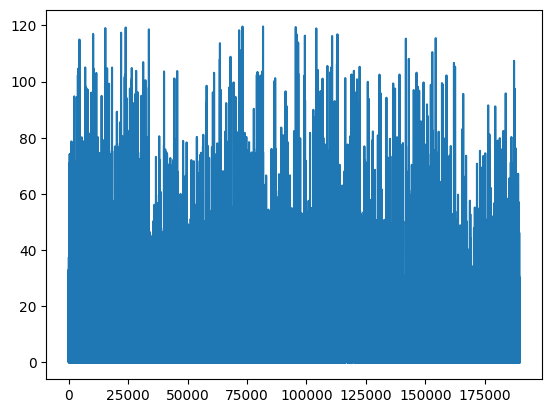

In [ ]:
import matplotlib.pyplot as plt
plt.plot(evento['duracion_h'])
plt.show()

In [ ]:
evento[evento['duracion_h']>5000]

,evento,equipo_ope,tipo_equi_ope,cto_equi_ope,tipo_elemento,inicio,fin,duracion_h,tipo_duracion,causa,CNT_TRAFOS_AFEC,cnt_usus,SAIDI,SAIFI


# REDMT

Aquí tienes un resumen de las transformaciones y los cambios en las columnas del DataFrame `a` en tu código, enumerado por cada acción relevante:

### Cambios en columnas existentes:

1. **`KVNOM`**:
   - **Filtrado**: Se filtran las filas donde `'KVNOM' == 13.2'`.

2. **`PHASES`**:
   - **Transformación**: Se reemplazan los valores de la columna utilizando el diccionario `phases_dict`. El valor 8 se reemplaza con 0.

3. **`CONDUCTOR`**:
   - **Transformación**: Se eliminan los espacios en blanco alrededor de los valores y se cambia a tipo `str`.
   - **Combinación**: Se realiza un `merge` con el DataFrame `auxb` (de `'Parámetros_varios.xlsx'`) en la columna `'CONDUCTOR'`, añadiendo nuevas columnas relacionadas con el conductor.

4. **`NEUTRAL`**:
   - **Relleno**: Los valores faltantes se rellenan con `'No aplica'`.
   - **Combinación**: Se realiza un `merge` con `auxb_neutral`, añadiendo una nueva columna `'CALIBRENEUTRO'` para el calibre del conductor neutro.
   - **Transformación**: Se eliminan los espacios en blanco y se cambia a tipo `str`.

5. **`OWNER`**:
   - **Relleno**: Los valores nulos se rellenan con una cadena vacía.
   - **Transformación**: Se convierte a minúsculas.
   - **Clasificación**: Los valores se transforman en `'C'` si el valor está en la lista de `valores_C` (['chec', 'epm', '']), de lo contrario, se asigna `'P'`.
   - **Eliminación**: La columna se elimina más adelante en el proceso.

6. **`TOWNER`**:
   - **Relleno**: Se reemplaza el valor vacío de `'TOWNER'` con el valor de `'OWNER'` cuando `'TOWNER'` está vacío.
   - **Asignación**: Los valores vacíos restantes en `'TOWNER'` se rellenan con `'C'`.

7. **`DATE_`**:
   - **Conversión**: Se convierte a tipo `datetime`, manejando posibles errores.
   - **Relleno**: Los valores faltantes se reemplazan con una fecha por defecto ('01/01/1900').

8. **`DATE_REM`**:
   - **Conversión**: Se convierte a tipo `datetime`, manejando posibles errores.
   - **Relleno**: Los valores faltantes se reemplazan con la misma fecha por defecto ('01/01/1900').

9. **`FECHA_ACT`** (Nueva columna):
   - **Creación**: Se calcula como el valor máximo entre `'DATE_'` y `'DATE_REM'`.

10. **`FECHA`**:
    - **Conversión**: Se convierte a tipo `datetime`, manejando errores.

### Nuevas columnas creadas:

1. **`CALIBRENEUTRO`**:
   - **Creación**: Esta columna se añade después del `merge` con el DataFrame de conductores neutros (`auxb_neutral`).

2. **`FECHA_ACT`**:
   - **Creación**: Se añade para representar la fecha más reciente entre `'DATE_'` y `'DATE_REM'`.

### Columnas eliminadas:

1. **`OWNER`**
2. **`KVNOM`**
3. **`DATE_REM`**
4. **`DATE_`**

### Columnas renombradas:

1. **`FPARENT`**:
   - **Renombrado**: Se renombra como `'FPARENT*'`.

Este resumen cubre todas las transformaciones, eliminaciones, y columnas nuevas que fueron introducidas en el DataFrame `a`.

In [ ]:
import numpy as np
import pandas as pd

phases_dict = {
    1: 1,
    2: 1,
    3: 2,
    4: 1,
    5: 2,
    6: 2,
    7: 3,
    9: 1,
    8: 0,
    10: 1,
    11: 2,
    12: 1,
    13: 2,
    14: 2,
    15: 3
}
path='/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
a=pd.read_csv(path+'REDMT.csv',low_memory=False)
print(a.shape)
#33.   , 115.   ,  13.2  , 230.   ,   7.62 ,   7.621,   7.6
a=a[(a['KVNOM']==13.2)|(a['KVNOM']==33)|(a['KVNOM']==7.62)|(a['KVNOM']==7.621)|(a['KVNOM']==7.6)]
a['PHASES']=a['PHASES'].replace(phases_dict)#OJO 8 ==0? no tenemos 8 en la tabla
#auxa=a[['CONDUCTOR']]
b=pd.read_excel('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Parámetros_varios.xlsx',sheet_name='conductores')
a['NEUTRAL'].fillna('No aplica', inplace=True)
# Paso 1: Preparar los DataFrames y limpiar las columnas clave
auxb = b.copy()
a['CONDUCTOR'] = a['CONDUCTOR'].astype(str).str.strip()
auxb['CODIGOCONDUCTOR'] = auxb['CODIGOCONDUCTOR'].astype(str).str.strip()
col_names = auxb.columns.tolist()
col_rename_dict = {}
for i in col_names:
    if i in ['CODIGOCONDUCTOR','CONDUCTOR','MATERIALCONDUCTOR','TIPOCONDUCTOR','CALIBRECONDUCTOR']:
        col_rename_dict[i] = i  # Mantener el nombre original
    else:
        col_rename_dict[i] = i + 'CONDUCTOR'  # Agregar 'CONDUCTOR' al final
# Paso 4: Renombrar las columnas de 'auxb' usando el diccionario
auxb.rename(columns=col_rename_dict, inplace=True)
# Paso 3: Realizar el merge con la variable 'CONDUCTOR'
a = a.merge(auxb, left_on='CONDUCTOR', right_on='CODIGOCONDUCTOR', how='left')
a.drop('CODIGOCONDUCTOR', axis=1, inplace=True)
# Paso 4: Preparar el segundo merge con 'NEUTRAL'
a['NEUTRAL'] = a['NEUTRAL'].astype(str).str.strip()


auxb_neutral = b[['CODIGOCONDUCTOR', 'NEUTRO','CALIBRECONDUCTOR']].copy()
auxb_neutral['CODIGOCONDUCTOR'] = auxb_neutral['CODIGOCONDUCTOR'].astype(str).str.strip()
auxb_neutral.rename(columns={'CALIBRECONDUCTOR': 'CALIBRENEUTRO'}, inplace=True)
# Paso 5: Realizar el merge con la variable 'NEUTRAL'

a = a.merge(auxb_neutral, left_on='NEUTRAL', right_on='CODIGOCONDUCTOR', how='left')

a.drop('CODIGOCONDUCTOR', axis=1, inplace=True)


a['NEUTRO'].fillna('No aplica', inplace=True)
a['CALIBRENEUTRO'].fillna('No aplica', inplace=True)
# Paso 1: Reemplazar NaN por cadena vacía y eliminar espacios
a['OWNER'] = a['OWNER'].fillna('').astype(str).str.strip()
# Paso 2: Convertir a minúsculas
a['OWNER'] = a['OWNER'].str.lower()
# Paso 3: Definir los valores que deben ser 'C'
valores_C = ['chec','emp','epm','c','CHEC','EMP','EPM','C']
# Paso 4: Aplicar la transformación
a['OWNER'] = np.where(a['OWNER'].isin(valores_C), 'C', 'P')
# Supongamos que tu DataFrame es 'df'
# Paso 1: Preparar las columnas
a['TOWNER'] = a['TOWNER'].fillna('').astype(str).str.strip()
a['OWNER'] = a['OWNER'].fillna('').astype(str).str.strip()
# Paso 2: Rellenar 'OWNER' vacío con 'TOWNER'
a.loc[a['TOWNER'] == '', 'TOWNER'] = a['OWNER']
# Paso 3: Asignar 'C' a los 'OWNER' que siguen vacíos
a.loc[a['TOWNER'] == '', 'TOWNER'] = 'C'
from datetime import datetime
# Supongamos que tu DataFrame se llama 'a'
# Paso 1: Convertir las columnas a formato datetime
a['DATE_'] = pd.to_datetime(a['DATE_'], errors='coerce')
a['DATE_REM'] = pd.to_datetime(a['DATE_REM'], errors='coerce')
# Paso 2: Definir la fecha por defecto para valores faltantes
default_date = datetime.strptime('01/01/1900 00:00:00', '%d/%m/%Y %H:%M:%S')
# Paso 3: Rellenar los valores faltantes con la fecha por defecto
a['DATE_'] = a['DATE_'].fillna(default_date)
a['DATE_REM'] = a['DATE_REM'].fillna(default_date)
# Paso 4: Obtener el máximo entre 'DATE_' y 'DATE_REM' por fila
a['FECHA_ACT'] = a[['DATE_', 'DATE_REM']].max(axis=1)
a['FECHA'] = pd.to_datetime(a['FECHA'], errors='coerce')
a.drop(['OWNER','DATE_REM','DATE_'],axis=1,inplace=True)
#a.rename(columns={'FPARENT': 'FPARENT*'}, inplace=True)
print(a.shape)
c=pd.read_excel('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Conductores.xlsx')
auxc = c[['CODE', 'CAPACITY', 'RESISTANCE']].copy()
auxc['CODE'] = auxc['CODE'].astype(str).str.strip()
auxc.rename(columns={'CODE': 'CONDUCTOR'}, inplace=True)
# Paso 5: Realizar el merge con la variable 'NEUTRAL'
a=a.merge(auxc, on='CONDUCTOR', how='left')
#a.drop('CODE*', axis=1, inplace=True)
###FILTRO AEREO
# Configurar la transformación específica para EPSG:3115

transformer = Transformer.from_crs("EPSG:3115", "EPSG:4326", always_xy=True)
a['LONGITUD'], a['LATITUD'] = zip(*a.apply(lambda row: transformer.transform(row['XPOS1'], row['YPOS1']), axis=1))
a['LONGITUD2'], a['LATITUD2'] = zip(*a.apply(lambda row: transformer.transform(row['XPOS2'], row['YPOS2']), axis=1))
a.drop(['XPOS1','YPOS1','XPOS2','YPOS2'],axis=1,inplace=True)

# Convertir XPOS y YPOS a latitud y longitud
coord_referencia = m[['Latitud', 'Longitud']].values
coord_original = a[['LATITUD2', 'LONGITUD2']].values
# Crear el árbol KD con las coordenadas de referencia
tree = cKDTree(coord_referencia)
# Encontrar el índice del punto más cercano en a para cada coordenada en df
distancias, indices_mas_cercanos = tree.query(coord_original, k=1)
# Asignar municipio y departamento más cercano a cada punto en el DataFrame original
a['DEP'] = m.iloc[indices_mas_cercanos]['Nombre Departamento'].values
a['MUN'] = m.iloc[indices_mas_cercanos]['Nombre Municipio'].values
a.dropna(inplace=True)
a.to_csv(output_path+'REDMT.csv',index=False)
redmt=a.copy()

(4346747, 20)


<ipython-input-9-babab3353c41>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  a['NEUTRAL'].fillna('No aplica', inplace=True)
<ipython-input-9-babab3353c41>:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

(4239722, 31)


In [ ]:
pd.DataFrame({
                'Columna': a.columns,
                'Tipo de Dato': [str(a[col].dtype) for col in a.columns],
                'Porcentaje de Vacíos': [(a[col].isnull().mean() * 100) for col in a.columns]
            })

,Columna,Tipo de Dato,Porcentaje de Vacíos
0,CODE,object,0.0
1,PHASES,int64,0.0
2,FPARENT,object,0.0
3,ELNODE1,object,0.0
4,ELNODE2,object,0.0
5,CONDUCTOR,object,0.0
6,NEUTRAL,object,0.0
7,LENGTH,float64,0.0
8,KVNOM,float64,0.0
9,ORDER_,int64,0.0


In [ ]:
#a[a['CAPACITY'].isna()].groupby('CONDUCTOR').count().to_excel('REDMT_NA.xlsx')

#Apoyos


Aquí está el resumen de los cambios, organizados por columnas y enumerando cada detalle, incluyendo columnas nuevas, eliminadas, creadas o transformadas:

### Cambios en columnas existentes:

1. **`ASSEMBLY`**:
   - **Transformación**: Se reemplazan los valores cuando `'TIPO'` está vacío usando el `'ASSEMBLY'` más reciente basado en la columna `'FECHA'` para cada `'CODE'`.

2. **`LONG_APOYO`**:
   - **Transformación**: Se asignan valores específicos para `'FICTICIO'` (10), `'PORTICO'` (10), y `'FACHADA'` (6).
   - **Conversión**: Se transforma a tipo `float`.

3. **`MATERIAL`**:
   - **Transformación**: Se reemplazan los códigos por descripciones más detalladas utilizando el diccionario `materiales_dict`.

4. **`TIPO`**:
   - **Filtrado**: Se eliminan filas donde `'TIPO' != 'A'`.
   - **Eliminación**: La columna se elimina después del filtrado.

5. **`CLASE`**:
   - **Filtrado**: Se eliminan filas donde `'CLASE' != 'F'`.
   - **Eliminación**: La columna se elimina después del filtrado.

6. **`FECHA`**:
   - **Conversión**: Se convierte a tipo `datetime`.

7. **`TOWNER`**:
   - **Relleno**: Se rellena con el valor `'C'` donde hay valores nulos.

8. **`TIERRA_PIE`**:
   - **Relleno**: Se rellena con `'No aplica'` donde hay valores faltantes.

9. **`VIEN_SEC`**:
   - **Conversión**: Se transforma a tipo `float`.

### Nuevas columnas creadas:

1. **`Z*`**:
   - **Creación**: Se renombra la columna `'Z'` a `'Z*'`.

2. **`VIEN_PRIM*`**:
   - **Creación**: Se renombra la columna `'VIEN_PRIM'` a `'VIEN_PRIM*'`.

### Columnas eliminadas:

1. **`TIPO`**
2. **`CLASE`**

Este es el resumen de todas las transformaciones, columnas nuevas, y las que fueron eliminadas.

In [ ]:
c=pd.read_csv(path+'NODOS_ELECTRICOS.csv')
c['FECHA'] = pd.to_datetime(c['FECHA'])#.dt.to_period('M')
c['FECHA_C'] = c['FECHA'].dt.to_period('M')
import pandas as pd
path='/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
a=pd.read_csv(path+'APOYOS.csv',low_memory=False)
print(a.shape)
a['FECHA'] = pd.to_datetime(a['FECHA'])#.dt.to_period('M')
a['FECHA_C'] = a['FECHA'].dt.to_period('M')
c1=c[['CODE','PHNODE','FECHA_C']]
c1.rename(columns={'CODE':'CODE_NE'},inplace=True)
a=pd.merge(a,c1,left_on=['CODE','FECHA_C'],right_on=['PHNODE','FECHA_C'],how='inner')
a.drop_duplicates(inplace=True)
print(a.shape)
redmt['FECHA_C'] = redmt['FECHA'].dt.to_period('M')
c1=redmt[['ELNODE1','FECHA_C']]
c1.rename(columns={'ELNODE1':'CODE_NE'},inplace=True)
a1=pd.merge(a,c1,on=['CODE_NE','FECHA_C'],how='inner')
c2=redmt[['ELNODE2','FECHA_C']]
c2.rename(columns={'ELNODE2':'CODE_NE'},inplace=True)
a2=pd.merge(a,c2,on=['CODE_NE','FECHA_C'],how='inner')
a=pd.concat([a1[['CODE', 'ASSEMBLY','XPOS','YPOS','TOWNER','FECHA']],a2[['CODE', 'ASSEMBLY','XPOS','YPOS','TOWNER','FECHA']]]).drop_duplicates()
print(a.shape)
columns=a.columns
b=pd.read_excel('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Parámetros_varios.xlsx',sheet_name='nf_ne')
materiales_dict = {
    'B': 'Tubo metálico',
    'K': 'Torre metálica cuadrada',
    'C': 'Torrecilla cuadrada',
    'H': 'Torrecilla metálica triangular',
    'R': 'Riel',
    'P': 'Poste metálico',
    'V': 'Poste de fibra de vidrio',
    'M': 'Poste en madera',
    'T': 'Poste en Concreto',
    'I': 'Poste concreto sección I',
    'S': 'Torre Auto Soportada',
    'Z': 'Angulo enterrado',
    'G': 'Torre tipo guacaica'
}
VIEN_PRIM_DICT={
    'A': 10,
    'B': 11,
    'C': 12,
    'D': 13,
    'E': 14,
    'F': 15,
    'G': 16
}
auxb=b[['ASSEMBLY','TIPO','CLASE','MATERIAL','LONG_APOYO','VIEN_PRIM','VIEN_SEC','TIERRA_PIE']]#0,T,nan
auxb=auxb[auxb['CLASE']=='F']
# Usando .loc para evitar el SettingWithCopyWarning
import pandas as pd
import numpy as np
#a.loc[:, 'ASSEMBLY'] = a['ASSEMBLY'].astype(str).str.strip()
#auxb.loc[:, 'ASSEMBLY'] = auxb['ASSEMBLY'].astype(str).str.strip()
# Luego realizas el merge
a = a.merge(auxb, on='ASSEMBLY', how='left')
a.loc[a['ASSEMBLY'] == 'FICTICIO', 'LONG_APOYO'] = 10
a.loc[a['ASSEMBLY'] == 'PORTICO', 'LONG_APOYO'] = 10
a.loc[a['ASSEMBLY'] == 'FACHADA', 'LONG_APOYO'] = 6
a['MATERIAL'] = a['MATERIAL'].replace(materiales_dict)
# a=a[(a['CLASE']=='F')]

# Asegurar que 'FECHA' es de tipo datetime
# Identificar filas donde 'TIPO' está vacío
empty_tipo = a['TIPO'].isnull() | a['TIPO'].eq('')
# Filtrar y ordenar filas donde 'TIPO' no está vacío
df_non_empty_tipo_sorted = a[~empty_tipo].sort_values('FECHA')
# Obtener el último 'ASSEMBLY' por 'CODE'
latest_rows = df_non_empty_tipo_sorted.groupby('CODE').tail(1)
code_to_assembly = latest_rows.set_index('CODE')['ASSEMBLY'].to_dict()
# Reemplazar 'ASSEMBLY' en filas donde 'TIPO' está vacío
a.loc[empty_tipo, 'ASSEMBLY'] = a.loc[empty_tipo, 'CODE'].map(code_to_assembly).fillna(a.loc[empty_tipo, 'ASSEMBLY'])
a=a[np.array(columns)]
a = a.merge(auxb, on='ASSEMBLY', how='left')
a.loc[a['ASSEMBLY'] == 'FICTICIO', 'LONG_APOYO'] = 10
a.loc[a['ASSEMBLY'] == 'PORTICO', 'LONG_APOYO'] = 10
a.loc[a['ASSEMBLY'] == 'FACHADA', 'LONG_APOYO'] = 6
a['MATERIAL'] = a['MATERIAL'].replace(materiales_dict)
# a.fillna('NA',inplace=True)

a['TOWNER'].fillna('C', inplace=True)
a['LONG_APOYO'] = a['LONG_APOYO'].astype(float)
#a.drop(['CLASE'],inplace=True,axis=1)
#a['TIERRA_PIE'].fillna('No aplica', inplace=True)
#a['TIERRA_PIE'].fillna('NA', inplace=True)
a['VIEN_SEC'] = a['VIEN_SEC'].astype(float)
a['VIEN_PRIM'] = a['VIEN_PRIM'].replace(VIEN_PRIM_DICT)
a['VIENTOS']=a['VIEN_PRIM']+a['VIEN_SEC']
a.drop(['VIEN_SEC','VIEN_PRIM'],inplace=True,axis=1)
#a.rename(columns={'Z': 'Z*', 'VIEN_PRIM': 'VIEN_PRIM*'}, inplace=True)
a.loc[(a['CLASE']=='F')&(~a['MATERIAL'].isna())&(a['TIERRA_PIE'].isna()),['TIERRA_PIE']]=0
a.loc[(a['CLASE'] == 'F')&(a['MATERIAL'].isna()), ['MATERIAL', 'TIERRA_PIE', 'VIENTOS']] = 'No aplica'
a.loc[(a['CLASE'] == 'F')&(a['LONG_APOYO'].isna()), ['LONG_APOYO']] = 'No aplica'


transformer = Transformer.from_crs("EPSG:3115", "EPSG:4326", always_xy=True)
a['LONGITUD'], a['LATITUD'] = zip(*a.apply(lambda row: transformer.transform(row['XPOS'], row['YPOS']), axis=1))
a.drop(['XPOS','YPOS'],axis=1,inplace=True)

# Convertir XPOS y YPOS a latitud y longitud
coord_referencia = m[['Latitud', 'Longitud']].values
coord_original = a[['LATITUD', 'LONGITUD']].values
# Crear el árbol KD con las coordenadas de referencia
tree = cKDTree(coord_referencia)
# Encontrar el índice del punto más cercano en a para cada coordenada en df
distancias, indices_mas_cercanos = tree.query(coord_original, k=1)
# Asignar municipio y departamento más cercano a cada punto en el DataFrame original
a['DEP'] = m.iloc[indices_mas_cercanos]['Nombre Departamento'].values
a['MUN'] = m.iloc[indices_mas_cercanos]['Nombre Municipio'].values
a.dropna(inplace=True)
a.to_csv(output_path+'APOYOS.csv',index=False)
print(a.shape)

(4153822, 6)


<ipython-input-12-22fb39e5ee46>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1.rename(columns={'CODE':'CODE_NE'},inplace=True)


(4400194, 9)


<ipython-input-12-22fb39e5ee46>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1.rename(columns={'ELNODE1':'CODE_NE'},inplace=True)
<ipython-input-12-22fb39e5ee46>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2.rename(columns={'ELNODE2':'CODE_NE'},inplace=True)


(3978252, 6)


<ipython-input-12-22fb39e5ee46>:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  a['TOWNER'].fillna('C', inplace=True)
<ipython-input-12-22fb39e5ee46>:89: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a['VIEN_PRIM'] = a['VIEN_PRIM'].replace(VIEN_PRIM_DICT)
<ipython-input-12-22fb39e5ee46>:94: Future

(3929487, 14)


In [ ]:
pd.DataFrame({
                'Columna': a.columns,
                'Tipo de Dato': [str(a[col].dtype) for col in a.columns],
                'Porcentaje de Vacíos': [(a[col].isnull().mean() * 100) for col in a.columns]
            })

,Columna,Tipo de Dato,Porcentaje de Vacíos
0,CODE,object,0.0
1,ASSEMBLY,object,0.0
2,TOWNER,object,0.0
3,FECHA,datetime64[ns],0.0
4,TIPO,object,0.0
5,CLASE,object,0.0
6,MATERIAL,object,0.0
7,LONG_APOYO,object,0.0
8,TIERRA_PIE,object,0.0
9,VIENTOS,object,0.0


#SWITCHES

Aquí está el resumen de las transformaciones y los cambios en las columnas del DataFrame `a` en este código, organizado por cada acción relevante:

### Cambios en columnas existentes:

1. **`KV`**:
   - **Filtrado**: Se filtran las filas donde `'KV' == 13.2'`.

2. **`PHASES`**:
   - **Transformación**: Se reemplazan los valores de la columna utilizando un diccionario (`phases_dict`). Esto mapea los valores de fases a sus representaciones numéricas.

3. **`ASSEMBLY`**:
   - **Transformación**: Se reemplazan los códigos de la columna `'ASSEMBLY'` con descripciones más detalladas utilizando el diccionario `codigo_dict`.

4. **`STATE`**:
   - **Transformación**: Se reemplazan los valores numéricos por descripciones más legibles utilizando el diccionario `state_dict`. Los valores 0 se reemplazan por `'Normalmente abierto'`, y los valores 3 y 7 por `'Normalmente cerrado'`.

5. **`FECHA`**:
   - **Conversión**: Se convierte a tipo `datetime`, asegurando que las fechas estén en el formato adecuado.

### Columnas eliminadas:

1. **`KV`**:
   - **Eliminación**: La columna `'KV'` se elimina después del filtrado por `'KV == 13.2'`.

### Columnas renombradas:

1. **`FPARENT`**:
   - **Renombrado**: Se renombra como `'FPARENT*'`.

2. **`ASSEMBLY`**:
   - **Renombrado**: Se renombra como `'ASSEMBLY*'` después de aplicar el diccionario de códigos.


In [ ]:
codigo_dict = {
    '1CR': 'Cortacircuito monofásico camara romperarco',
    '3RL': 'Reconectador trifásico en la línea',
    '3RG': 'Reconectador trifásico General',
    '1CFR': 'Cortacircuito monofásico con fusible de repetición',
    '2CFR': 'Cortacircuito bifásico con fusible de repetición',
    '1CC': 'Cortacircuito monofásico',
    '2CC': 'Cortacircuito bifásico - Caja Vela',
    '3CC': 'Cortacircuito trifásico - Caja Vela',
    '2CR': 'Cortacircuito bifásico camara romperarco',
    '3CR': 'Cortacircuito trifásico con cámara romperarco',
    '3OS': 'Seccionador trifásico de operación sin carga o Cuchillas',
    '3OC': 'Seccionador trifásico de operación con carga',
    '3SC': 'Seccionador operación con carga y Cuchillas',
    'ARCOS': 'ARCOS',
    '3CFR': 'Cortacircuito trifásico con fusible de repetición'
}
state_dict = {
    0: 'Normalmente abierto ',
    3: 'Normalmente cerrado',
    7: 'Normalmente cerrado',
}
path='/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
a=pd.read_csv(path+'SWITCHES.csv',low_memory=False)
columns=a.columns
print(a.shape)
b=pd.read_excel('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Parámetros_varios.xlsx',sheet_name='conductores')
#a=a[a['KV']==13.2]
a=a[(a['KV']==13.2)|(a['KV']==33)|(a['KV']==7.62)|(a['KV']==7.621)|(a['KV']==7.6)]
a['PHASES']=a['PHASES'].replace(phases_dict)
a['ASSEMBLY']=a['ASSEMBLY'].replace(codigo_dict)
a['STATE']=a['STATE'].replace(state_dict)
a['FECHA'] = pd.to_datetime(a['FECHA'])
empty_tipo = a['ASSEMBLY'].isnull() | a['ASSEMBLY'].eq('')
# Filtrar y ordenar filas donde 'TIPO' no está vacío
df_non_empty_tipo_sorted = a[~empty_tipo].sort_values('FECHA')
# Obtener el último 'ASSEMBLY' por 'CODE'
latest_rows = df_non_empty_tipo_sorted.groupby('CODE').tail(1)
code_to_assembly = latest_rows.set_index('CODE')['ASSEMBLY'].to_dict()
# Reemplazar 'ASSEMBLY' en filas donde 'TIPO' está vacío
a.loc[empty_tipo, 'ASSEMBLY'] = a.loc[empty_tipo, 'CODE'].map(code_to_assembly).fillna(a.loc[empty_tipo, 'ASSEMBLY'])
a=a[np.array(columns)]
#a.drop(['KV'],axis=1,inplace=True)
#a.rename(columns={'FPARENT': 'FPARENT*','ASSEMBLY':'ASSEMBLY*'}, inplace=True)
#a['STATE'].unique()0 < normalmente abierto, demás normalment e0 diferente cerrado7,3
a['FECHA_C']=a['FECHA'].dt.to_period('M')
a.drop_duplicates(subset=['CODE', 'FECHA_C'],inplace=True)
a.drop('FECHA_C',axis=1,inplace=True)

transformer = Transformer.from_crs("EPSG:3115", "EPSG:4326", always_xy=True)
a['LONGITUD'], a['LATITUD'] = zip(*a.apply(lambda row: transformer.transform(row['XPOS'], row['YPOS']), axis=1))
a.drop(['XPOS','YPOS'],axis=1,inplace=True)

# Convertir XPOS y YPOS a latitud y longitud
coord_referencia = m[['Latitud', 'Longitud']].values
coord_original = a[['LATITUD', 'LONGITUD']].values
# Crear el árbol KD con las coordenadas de referencia
tree = cKDTree(coord_referencia)
# Encontrar el índice del punto más cercano en a para cada coordenada en df
distancias, indices_mas_cercanos = tree.query(coord_original, k=1)
# Asignar municipio y departamento más cercano a cada punto en el DataFrame original
a['DEP'] = m.iloc[indices_mas_cercanos]['Nombre Departamento'].values
a['MUN'] = m.iloc[indices_mas_cercanos]['Nombre Municipio'].values
a.dropna(inplace=True)
a.to_csv(output_path+'SWITCHES.csv',index=False)
switches=a.copy()

(625208, 10)


In [ ]:
pd.DataFrame({
                'Columna': a.columns,
                'Tipo de Dato': [str(a[col].dtype) for col in a.columns],
                'Porcentaje de Vacíos': [(a[col].isnull().mean() * 100) for col in a.columns]
            })
#ASSEMLY Samplear del pasado

,Columna,Tipo de Dato,Porcentaje de Vacíos
0,CODE,object,0.0
1,ASSEMBLY,object,0.0
2,PHASES,int64,0.0
3,FPARENT,object,0.0
4,KV,float64,0.0
5,STATE,object,0.0
6,LINESECTIO,object,0.0
7,FECHA,datetime64[ns],0.0
8,LONGITUD,float64,0.0
9,LATITUD,float64,0.0


In [ ]:
#a[(a['ASSEMBLY'].isna())].groupby('CODE').count().to_excel('SWITCHES_NA.xlsx')    #ARM-->eliminar,enviar lista#ARMEliminar,JTG

#TRAFOS

In [ ]:
Owner_dict = {
    'S': 'C',
    'N': 'P'
}
subestaciones_dict = {
    1: 'Subestación de patio de alta y extra alta tensión',
    2: 'Subestación de alta y extra alta tensión tipo interior',
    3: 'Subestación de patio de distribución de media tensión',
    4: 'Subestaciones en interiores de distribución en media tensión',
    5: 'Subestaciones en interiores de edificaciones',
    6: 'Subestaciones tipo pedestal',
    7: 'Subestaciones sumergibles',
    8: 'Subestaciones semisumergibles',
    9: 'Subestaciones de distribución tipo poste',
    0: 'Subestación de patio híbrida de media y alta tensión'
}

path='/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
a=pd.read_csv(path+'TRAFOS.csv',low_memory=False)
print(a.shape)
a['PHASES']=a['PHASES'].replace(phases_dict)
a['OWNER1']=a['OWNER1'].replace(Owner_dict)
a['TIPO_SUB']=a['TIPO_SUB'].replace(subestaciones_dict)#Vacios
# Paso 1: Convertir las columnas a formato datetime
a['FECHA'] = pd.to_datetime(a['FECHA'])
a['DATE_FAB'] = pd.to_datetime(a['DATE_FAB'], errors='coerce')
a['DATE_INST'] = pd.to_datetime(a['DATE_INST'], errors='coerce')##111
a['DATE_REM'] = pd.to_datetime(a['DATE_REM'], errors='coerce')#222222
# Paso 2: Definir la fecha por defecto para valores faltantes
default_date = datetime.strptime('01/01/1900 00:00:00', '%d/%m/%Y %H:%M:%S')
# Paso 3: Rellenar los valores faltantes con la fecha por defecto
a['DATE_FAB'] = a['DATE_FAB'].fillna(default_date)
a['DATE_INST'] = a['DATE_INST'].fillna(default_date)
a['DATE_REM'] = a['DATE_REM'].fillna(default_date)
a['FECHA_ACT'] = a[['DATE_REM','DATE_INST']].max(axis=1)
a.drop(['DATE_REM','DATE_INST'],axis=1,inplace=True)
#a.rename(columns={'FPARENT': 'FPARENT*','Z':'Z*','IMPEDANCE':'IMPEDANCE*','MARCA':'MARCA*',
#                  'TIPO_SUB':'TIPO_SUB*','CASO':'CASO*'}, inplace=True)
#a['CASO'].fillna('NA', inplace=True)
#a.to_csv(path+'TRAFOS.csv',index=False)

c=pd.read_excel('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Parámetros_varios.xlsx',sheet_name='trftypes')
auxc=c[['CODE', 'KVA', 'KV1']]
a['TRFTYPE'] = a['TRFTYPE'].astype(str).str.strip()
auxc['CODE'] = auxc['CODE'].astype(str).str.strip()
auxc.rename(columns={'CODE': 'TRFTYPE'}, inplace=True)
a = a.merge(auxc, on='TRFTYPE', how='left')
#a.drop('CODE_y', axis=1, inplace=True)
#a.rename(columns={'CODE_x': 'CODE'}, inplace=True)
a=a[a['KV1']!=115.]
transformer = Transformer.from_crs("EPSG:3115", "EPSG:4326", always_xy=True)
a['LONGITUD'], a['LATITUD'] = zip(*a.apply(lambda row: transformer.transform(row['XPOS'], row['YPOS']), axis=1))
a.drop(['XPOS','YPOS'],axis=1,inplace=True)

# Convertir XPOS y YPOS a latitud y longitud
coord_referencia = m[['Latitud', 'Longitud']].values
coord_original = a[['LATITUD', 'LONGITUD']].values
# Crear el árbol KD con las coordenadas de referencia
tree = cKDTree(coord_referencia)
# Encontrar el índice del punto más cercano en a para cada coordenada en df
distancias, indices_mas_cercanos = tree.query(coord_original, k=1)
# Asignar municipio y departamento más cercano a cada punto en el DataFrame original
a['DEP'] = m.iloc[indices_mas_cercanos]['Nombre Departamento'].values
a['MUN'] = m.iloc[indices_mas_cercanos]['Nombre Municipio'].values
a.dropna(inplace=True)
a.to_csv(output_path+'TRAFOS.csv',index=False)
trafos=a.copy()

(1428187, 16)


<ipython-input-17-4ea79b6b73a7>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auxc['CODE'] = auxc['CODE'].astype(str).str.strip()
<ipython-input-17-4ea79b6b73a7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auxc.rename(columns={'CODE': 'TRFTYPE'}, inplace=True)


In [ ]:
pd.DataFrame({
                'Columna': a.columns,
                'Tipo de Dato': [str(a[col].dtype) for col in a.columns],
                'Porcentaje de Vacíos': [(a[col].isnull().mean() * 100) for col in a.columns]
            })

,Columna,Tipo de Dato,Porcentaje de Vacíos
0,CODE,object,0.0
1,PHASES,int64,0.0
2,FPARENT,object,0.0
3,OWNER1,object,0.0
4,TRFTYPE,object,0.0
5,ELNODE,object,0.0
6,IMPEDANCE,float64,0.0
7,DATE_FAB,datetime64[ns],0.0
8,MARCA,object,0.0
9,TIPO_SUB,object,0.0


In [ ]:
# a[a['MARCA'].isna()].groupby('CODE').count().to_excel('TRAFOS_SIN_MARCA.xlsx')#


In [ ]:
# a[a['TIPO_SUB'].isna()].groupby('CODE').count().to_excel('TRAFOS_SIN_TIPO_SUB.xlsx')

#RAYOS

In [ ]:
path='/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
a=pd.read_csv(path+'Rayos.csv',low_memory=False)
import pandas as pd

# Crear una nueva columna 'FECHA' combinando las columnas existentes y forzando la conversión a enteros
a['FECHA'] = a.apply(lambda row: f"{int(row['A_COL'])}-{int(row['MES_COL']):02d}-{int(row['DIA_COL']):02d} {int(row['HORA_COL']):02d}:{int(row['MINUTO']):02d}:{int(row['SEGUNDO']):02d}", axis=1)

# Convertir la columna 'FECHA' a formato datetime
a['FECHA'] = pd.to_datetime(a['FECHA'], errors='coerce')

# Eliminar las columnas originales si ya no se necesitan
a = a.drop(columns=['A_COL', 'MES_COL', 'DIA_COL', 'HORA_COL', 'MINUTO', 'SEGUNDO'])

# Convertir XPOS y YPOS a latitud y longitud
coord_referencia = m[['Latitud', 'Longitud']].values
coord_original = a[['LATITUD', 'LONGITUD']].values
# Crear el árbol KD con las coordenadas de referencia
tree = cKDTree(coord_referencia)
# Encontrar el índice del punto más cercano en a para cada coordenada en df
distancias, indices_mas_cercanos = tree.query(coord_original, k=1)
# Asignar municipio y departamento más cercano a cada punto en el DataFrame original
a['DEP'] = m.iloc[indices_mas_cercanos]['Nombre Departamento'].values
a['MUN'] = m.iloc[indices_mas_cercanos]['Nombre Municipio'].values
a.dropna(inplace=True)
a.to_csv(output_path+'Rayos.csv',index=False)

In [ ]:
pd.DataFrame({
                'Columna': a.columns,
                'Tipo de Dato': [str(a[col].dtype) for col in a.columns],
                'Porcentaje de Vacíos': [(a[col].isnull().mean() * 100) for col in a.columns]
            })

,Columna,Tipo de Dato,Porcentaje de Vacíos
0,ID,int64,0.0
1,LATITUD,float64,0.0
2,LONGITUD,float64,0.0
3,ALTITUD,object,0.0
4,TIPO,int64,0.0
5,CORRIENTE,float64,0.0
6,ERROR,object,0.0
7,CODE,object,0.0
8,FPARENT,object,0.0
9,DISTANCIA_A_NODO,float64,0.0


In [ ]:
a

,ID,LATITUD,LONGITUD,ALTITUD,TIPO,CORRIENTE,ERROR,CODE,FPARENT,DISTANCIA_A_NODO,FECHA,DEP,MUN
1,202009191522446,4.9487,-75.5995,"12,4",2,-5.3,"0,016",1657,CHA23L16,78.252413,2020-09-03 14:15:22,CALDAS,VILLAMARÍA
2,2020076142486,4.9488,-75.7033,0,1,-5.8,"0,061",58412,INS23L13,24.710599,2020-07-10 01:01:42,RISARALDA,SANTA ROSA DE CABAL
3,20200784256395,4.9488,-75.6958,"6,6",2,5.2,"0,016",4244,INS23L13,35.126961,2020-07-04 03:42:56,RISARALDA,SANTA ROSA DE CABAL
4,202008193652495,4.6288,-75.6113,"10,1",2,5.0,"0,003",A186,ROS40L21,289.085969,2020-08-22 14:36:52,QUINDÍO,CIRCASIA
5,20200823350497,4.9488,-76.0051,0,1,-24.7,"0,145",36021,BOA23L14,354.305040,2020-08-13 18:35:04,RISARALDA,BALBOA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681202,202307201941219,5.1550,-75.9733,10.3,2,-5.8,0.113,B2113,VBO30L12,176.426905,2023-07-02 15:19:41,RISARALDA,APÍA
1681203,2023072424124,5.1702,-75.5399,0.0,1,5.5,0.548,32806,NRA23L13,159.446963,2023-07-01 21:42:41,CALDAS,NEIRA
1681204,2023078322578,5.1795,-75.6513,0.0,1,7.6,0.452,B1574,IRR30L11,419.618993,2023-07-02 03:32:25,CALDAS,NEIRA
1681205,20230785612572,5.1909,-75.7204,0.0,1,-3.5,0.218,47568,RSA23L12,22.949051,2023-07-02 03:56:12,CALDAS,RISARALDA


In [4]:
path='/content/drive/Shareddrives/CHEC/data_chec/datos/Data_2019-2024/Merge/'
a=pd.read_csv(path+'VegetacionExistente.csv',low_memory=False)
s=a.copy()
b=a.copy()
import pandas as pd

# # Crear una nueva columna 'FECHA' combinando las columnas existentes y forzando la conversión a enteros
# a['FECHA'] = a.apply(lambda row: f"{int(row['A_COL'])}-{int(row['MES_COL']):02d}-{int(row['DIA_COL']):02d} {int(row['HORA_COL']):02d}:{int(row['MINUTO']):02d}:{int(row['SEGUNDO']):02d}", axis=1)

# # Convertir la columna 'FECHA' a formato datetime
a['FECHA'] = pd.to_datetime(a['FECHA'], errors='coerce')
a=a[['NOM_COMUN','TIPO_VEGET','ESTADO_INICIAL','FECHA','LADO_RED','DAP_ESTIM','LONG_INTER','TIPO_INTER','NIVEL_RIES','CIRCUITO_TRAMO','NODO_1','NODO_2','X','Y']]
a['X'] = a['X'].str.replace(',', '.').astype(float)
a['Y'] = a['Y'].str.replace(',', '.').astype(float)
a.rename(columns={'X': 'LONGITUD','Y': 'LATITUD'}, inplace=True)
# # Eliminar las columnas originales si ya no se necesitan
#transformer = Transformer.from_crs("EPSG:3115", "EPSG:4326", always_xy=True)
#a['LONGITUD'], a['LATITUD'] = zip(*a.apply(lambda row: transformer.transform(row['X'], row['Y']), axis=1))
#a.drop(['X','Y'],axis=1,inplace=True)
# Convertir XPOS y YPOS a latitud y longitud
coord_referencia = m[['Latitud', 'Longitud']].values
coord_original = a[['LATITUD', 'LONGITUD']].values
# Crear el árbol KD con las coordenadas de referencia
tree = cKDTree(coord_referencia)
# Encontrar el índice del punto más cercano en a para cada coordenada en df
distancias, indices_mas_cercanos = tree.query(coord_original, k=1)
# Asignar municipio y departamento más cercano a cada punto en el DataFrame original
a['DEP'] = m.iloc[indices_mas_cercanos]['Nombre Departamento'].values
a['MUN'] = m.iloc[indices_mas_cercanos]['Nombre Municipio'].values
print(a.shape)
a.dropna(inplace=True)
print(a.shape)
a.to_csv(output_path+'VegetacionExistente.csv',index=False)

<ipython-input-4-9925175a3658>:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  a['FECHA'] = pd.to_datetime(a['FECHA'], errors='coerce')


(43115, 16)
(18482, 16)


In [5]:
pd.DataFrame({
                'Columna': a.columns,
                'Tipo de Dato': [str(a[col].dtype) for col in a.columns],
                'Porcentaje de Vacíos': [(a[col].isnull().mean() * 100) for col in a.columns]
            })

,Columna,Tipo de Dato,Porcentaje de Vacíos
0,NOM_COMUN,object,0.0
1,TIPO_VEGET,object,0.0
2,ESTADO_INICIAL,object,0.0
3,FECHA,datetime64[ns],0.0
4,LADO_RED,object,0.0
5,DAP_ESTIM,int64,0.0
6,LONG_INTER,int64,0.0
7,TIPO_INTER,object,0.0
8,NIVEL_RIES,object,0.0
9,CIRCUITO_TRAMO,object,0.0


In [7]:
s

,OBJECTID,OT_MAXIMO,NOM_COMUN,TIPO_VEGET,ESTADO_INICIAL,FECHA,USUARIO,CANTIDAD,ALTURA_EST,ITEM_SERVICIO,...,TIPOS_CUERPOS_AGUA,CIRCUITO_TRAMO,FID_TRAMO,MUNICIPIO,DEPARTAMENTO,NODO_1,NODO_2,LONGITUD,X,Y
0,323,205536,YARUMO,Bosque natural,Nuevo,30/11/2023,FORESTAL_1,2,13,Poda en redes Rurales sin interrupción del ser...,...,NaN,ESM40L27,20537693.0,CHINCHINÁ,CALDAS,A06084,A06085,"440,4","-75,71430476","5,013049911"
1,324,205536,GUADUA,Guadual,Nuevo,30/11/2023,FORESTAL_1,20,14,Tala de guaduas T1,...,NaN,ESM40L27,20537698.0,CHINCHINÁ,CALDAS,A06089,A06090,"484,7","-75,72638738","5,023843242"
2,325,205806,MANDARINO,Frutales,Nuevo,30/11/2023,FORESTAL_1,1,7,Poda en redes Rurales sin interrupción del ser...,...,NaN,ESM40L28,20537846.0,CHINCHINÁ,CALDAS,A06059,A06060,"192,9","-75,64576844","4,992025226"
3,326,205536,GUAMO,Cafe/sombrio,Nuevo,30/11/2023,FORESTAL_1,1,9,Poda en redes Rurales sin interrupción del ser...,...,NaN,ESM40L27,20537718.0,PALESTINA,CALDAS,A06070,A06071,941,"-75,67465051","4,993295317"
4,327,205806,NaN,Otros,Nuevo,30/11/2023,FORESTAL_1,1,11,Poda en redes Rurales sin interrupción del ser...,...,NaN,ESM40L28,20537846.0,CHINCHINÁ,CALDAS,A06059,A06060,"192,9","-75,64576908","4,99203141"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43110,136331,323657,GUAMO SANTAFERENO,Arbol aislado,Ejecutado,10/09/2024,DMD81 - SUR 2,1,7,Poda en redes Rurales sin interrupción del ser...,...,NaN,PRO23L15,31306081.0,PUEBLO RICO,RISARALDA,O44412,O44930,"1202,11","-76,05456297","5,357649637"
43111,136332,323653,OTROS,Arbol aislado,Ejecutado,9/09/2024,DMD81 - SUR 2,1,12,Poda en redes Rurales sin interrupción del ser...,...,NaN,PRO23L15,40043639.0,PUEBLO RICO,RISARALDA,O44399,O44551,530,"-76,08285213","5,349755871"
43112,91936,311747,TACHUELO,Arbol aislado,Ejecutado,22/08/2024,DME85 - ORIENTE 6,1,12,Poda en redes Rurales sin interrupción del ser...,...,NaN,DON23L13,20475842.0,LA DORADA,CALDAS,L13405,L13406,"354,6","-74,67199907","5,565294887"
43113,131134,311805,GUAMO,Cafe/sombrio,Ejecutado,22/08/2024,DMN83 - NORTE 4,1,8,Poda en redes Rurales con interrupción del ser...,...,NaN,AMA23L16,20181552.0,GUÁTICA,RISARALDA,W30915,W30916,225,"-75,8222524","5,30290404"


In [6]:
#'NOM_COMUN','FID_TRAMO'

Index(['OBJECTID', 'OT_MAXIMO', 'NOM_COMUN', 'TIPO_VEGET', 'ESTADO_INICIAL',
       'FECHA', 'USUARIO', 'CANTIDAD', 'ALTURA_EST', 'ITEM_SERVICIO',
       'LADO_RED', 'DAP_ESTIM', 'DIST_VER_I', 'DIST_HOR_I', 'DIST_VER_F',
       'DIST_HOR_F', 'LONG_INTER', 'TIPO_INTER', 'NIVEL_RIES', 'REQ_PERM',
       'REALIZA_NOTI', 'PERMISO', 'RESTRICCIO', 'DURA_ACT', 'AUTORIDAD',
       'OBSERVACION', 'PERIODICIDAD', 'DIRECCION', 'ACCION_PROP',
       'ACCESO_VEHICULAR', 'TIEMPO', 'APAGON', 'DURACION_ESTIMADA', 'RECURSO',
       'GRUPOS', 'TRAMO', 'ESTADO_FIS', 'ASOCIADO_CUERPOS_AGUA',
       'TIPOS_CUERPOS_AGUA', 'CIRCUITO_TRAMO', 'FID_TRAMO', 'MUNICIPIO',
       'DEPARTAMENTO', 'NODO_1', 'NODO_2', 'LONGITUD', 'X', 'Y'],
      dtype='object')

In [ ]:
a

,NOM_COMUN,TIPO_VEGET,ESTADO_INICIAL,FECHA,LADO_RED,DAP_ESTIM,LONG_INTER,TIPO_INTER,NIVEL_RIES,CIRCUITO_TRAMO,NODO_1,NODO_2,LONGITUD,LATITUD,DEP,MUN
0,YARUMO,Bosque natural,Nuevo,2023-11-30,Debajo,22,6,Rocería,Medio,ESM40L27,A06084,A06085,-75.714305,5.013050,RISARALDA,MARSELLA
1,GUADUA,Guadual,Nuevo,2023-11-30,Debajo,11,6,Tala,Medio,ESM40L27,A06089,A06090,-75.726387,5.023843,RISARALDA,MARSELLA
2,MANDARINO,Frutales,Nuevo,2023-11-30,Debajo,28,6,Poda,Alto,ESM40L28,A06059,A06060,-75.645768,4.992025,CALDAS,CHINCHINÁ
3,GUAMO,Cafe/sombrio,Nuevo,2023-11-30,Debajo,45,6,Poda,Medio,ESM40L27,A06070,A06071,-75.674651,4.993295,CALDAS,CHINCHINÁ
5,GUADUA,Guadual,Nuevo,2023-11-30,Debajo,12,6,Tala,Medio,ESM40L27,A06087,A06088,-75.723988,5.018694,RISARALDA,MARSELLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43110,GUAMO SANTAFERENO,Arbol aislado,Ejecutado,2024-09-10,Debajo,20,2,Poda,Medio,PRO23L15,O44412,O44930,-76.054563,5.357650,RISARALDA,MISTRATÓ
43111,OTROS,Arbol aislado,Ejecutado,2024-09-09,Debajo,25,2,Poda,Medio,PRO23L15,O44399,O44551,-76.082852,5.349756,RISARALDA,PUEBLO RICO
43112,TACHUELO,Arbol aislado,Ejecutado,2024-08-22,Debajo,30,6,Poda,Alto,DON23L13,L13405,L13406,-74.671999,5.565295,CALDAS,LA DORADA
43113,GUAMO,Cafe/sombrio,Ejecutado,2024-08-22,Debajo,40,8,Poda,Medio,AMA23L16,W30915,W30916,-75.822252,5.302904,RISARALDA,GUÁTICA


In [ ]:
a[a['CIRCUITO_TRAMO']=='AGU23L14']

,NOM_COMUN,TIPO_VEGET,ESTADO_INICIAL,FECHA,LADO_RED,DAP_ESTIM,LONG_INTER,TIPO_INTER,NIVEL_RIES,CIRCUITO_TRAMO,NODO_1,NODO_2,LONGITUD,LATITUD,DEP,MUN
94,QUIEBRABARRIGO,Cerca Viva,Inspeccionado,2024-01-29,Izquierda,20,3,Poda,Medio,AGU23L14,N42209,N42210,-75.438242,5.648071,CALDAS,AGUADAS
95,PLATANO,Huerto,Inspeccionado,2024-01-29,Debajo,20,8,Poda,Alto,AGU23L14,N42206,N42220,-75.439559,5.644934,CALDAS,AGUADAS
97,PLATANO,Huerto,Ejecutado,2024-01-29,Debajo,20,15,Poda,Alto,AGU23L14,N42206,N42220,-75.439676,5.645047,CALDAS,AGUADAS
98,ARBOL DE LA CRUZ,Arbol aislado,Ejecutado,2024-01-29,Ambos Lados,30,4,Poda,Bajo,AGU23L14,N42217,N42226,-75.435699,5.652403,CALDAS,AGUADAS
99,MATARRATON,Cerca Viva,Ejecutado,2024-01-29,Ambos Lados,20,5,Poda,Medio,AGU23L14,N42216,N42232,-75.435512,5.653694,CALDAS,AGUADAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41790,ESPADERO,Bosque natural,Ejecutado,2024-09-03,Debajo,20,6,Poda,Alto,AGU23L14,N42027,N42028,-75.343452,5.576018,CALDAS,AGUADAS
41791,NN,Cerca Viva,Ejecutado,2024-09-03,Debajo,20,6,Poda,Alto,AGU23L14,N42460,N42462,-75.361101,5.585870,CALDAS,AGUADAS
41792,CIPRES,Arbol aislado,Inspeccionado,2024-09-03,Derecha,40,0,Poda,Alto,AGU23L14,N42496,N42497,-75.344096,5.576396,CALDAS,AGUADAS
41793,NN,Rastrojo,Inspeccionado,2024-09-03,Ambos Lados,0,5,Rocería,Alto,AGU23L14,N42496,N42497,-75.343966,5.576331,CALDAS,AGUADAS


In [ ]:
red=pd.read_csv('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_Total/REDMT.csv')
SW=pd.read_csv('/content/drive/Shareddrives/CHEC/data_chec/datos/Data_Total/SWITCHES.csv')

In [ ]:
red[(red['ELNODE1']=='L13405')|(red['ELNODE2']=='L13406')].iloc[-1:,:]

,CODE,PHASES,FPARENT,ELNODE1,ELNODE2,CONDUCTOR,NEUTRAL,LENGTH,KVNOM,ORDER_,...,CALIBRENEUTRO,FECHA_ACT,CAPACITY,RESISTANCE,LONGITUD,LATITUD,LONGITUD2,LATITUD2,DEP,MUN
4194605,51489,2,DON23L13,L13405,L13406,5A-0624,5A-0403,354.6,13.2,1,...,2024-04-01 00:00:00,2005-01-18 00:00:00,184.0,0.89095,-74.671969,5.564831,-74.672008,5.568032,CALDAS,LA DORADA


In [ ]:
SW['LINESECTIO']

,LINESECTIO
0,64640
1,28778
2,28779
3,29129
4,29136
...,...
613419,64963
613420,B6680100
613421,61059
613422,B3246


In [ ]:
aux=red[red['CODE']=='28778']
aux[aux['ELNODE1']=='AGU23L12']

,CODE,PHASES,FPARENT,ELNODE1,ELNODE2,CONDUCTOR,NEUTRAL,LENGTH,KVNOM,ORDER_,...,CALIBRENEUTRO,FECHA_ACT,CAPACITY,RESISTANCE,LONGITUD,LATITUD,LONGITUD2,LATITUD2,DEP,MUN
22692,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
82635,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
142625,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
202733,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
263035,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928997,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
3990189,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
4051383,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS
4112595,28778,3,AGU23L12,AGU23L12,N40002,5A-0626,5A-0624,16.4,13.2,1,...,2,1995-01-01 00:00:00,241.0,0.57543,-75.454912,5.607772,-75.454966,5.607907,CALDAS,AGUADAS


In [ ]:
red

,CODE,PHASES,FPARENT,ELNODE1,ELNODE2,CONDUCTOR,NEUTRAL,LENGTH,KVNOM,ORDER_,...,CALIBRENEUTRO,FECHA_ACT,CAPACITY,RESISTANCE,LONGITUD,LATITUD,LONGITUD2,LATITUD2,DEP,MUN
0,AGU_01,3,AGU30T11,AGU30T11,AGU30_23,5A-0626,5A-0403,17.8,33.0,1,...,2024-04-01 00:00:00,2010-04-28 09:46:04,241.0,0.57543,-75.454993,5.607826,-75.454840,5.607876,CALDAS,AGUADAS
1,AGU_02,3,AGU30T11,AGU23T11,AGU30_23,5A-0626,No aplica,17.2,33.0,-1,...,No aplica,2010-04-28 09:46:21,241.0,0.57543,-75.454993,5.607907,-75.454840,5.607876,CALDAS,AGUADAS
2,AGU30X1300,3,AGU30X13,AGU30X13,AGU30X13_01,5A-0624,5A-0624,27.4,33.0,1,...,2,2011-06-21 00:00:00,184.0,0.89095,-75.454992,5.607963,-75.454746,5.607963,CALDAS,AGUADAS
3,AMA23T1600,3,AMA23T16,AMA23T16,AMA23T16_01,5A-0624,5A-0624,8.0,13.2,1,...,2,2010-08-21 07:55:15,184.0,0.89095,-75.790115,5.226047,-75.790043,5.226043,CALDAS,ANSERMA
4,AMA30L18,3,AMA30L18,AMA30L18,B03054,5A-0324,5A-0324,9.4,33.0,1,...,500,1899-01-01 00:00:00,543.0,0.18730,-75.790305,5.225830,-75.790323,5.225749,CALDAS,ANSERMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211675,9994,3,HER23L12,D20339,D20342,5A-0628,5A-0628,66.8,13.2,1,...,2/0,1995-01-01 00:00:00,275.0,0.46476,-75.618187,4.864419,-75.618017,4.863840,RISARALDA,SANTA ROSA DE CABAL
4211676,9995,3,HER23L12,D20342,D20343,5A-0628,5A-0628,84.1,13.2,1,...,2/0,1995-01-01 00:00:00,275.0,0.46476,-75.618017,4.863840,-75.617784,4.863117,RISARALDA,SANTA ROSA DE CABAL
4211677,9997,3,HER23L12,D20344,D20345,5A-0628,5A-0628,48.4,13.2,1,...,2/0,1995-01-01 00:00:00,275.0,0.46476,-75.617551,4.862836,-75.617136,4.862971,RISARALDA,SANTA ROSA DE CABAL
4211678,9998,3,HER23L12,D20346,D20347,5A-0628,5A-0628,72.4,13.2,1,...,2/0,1995-01-01 00:00:00,275.0,0.46476,-75.618110,4.862684,-75.618732,4.862486,RISARALDA,SANTA ROSA DE CABAL


#Sumary

In [ ]:
prefixes = ["APOYOS", "EVENTOS", "REDMT", "SWITCHES",
            "TRAFOS"]
output_path = '/content/drive/Shareddrives/CHEC/data_chec/datos/Data_Total/'
output_excel = os.path.join(output_path, 'Resumen_Final.xlsx')
# Crear el archivo Excel con el resumen de columnas para cada prefijo
crear_excel_resumen(output_path ,prefixes, output_excel)
print(f"Archivo Excel de resumen guardado en: {output_excel}")

Resumen creado para APOYOS
Resumen creado para EVENTOS
Resumen creado para REDMT
Resumen creado para SWITCHES
Resumen creado para TRAFOS
Archivo Excel de resumen guardado en: /content/drive/Shareddrives/CHEC/data_chec/datos/Data_Total/Resumen_Final.xlsx


#Cruce

In [ ]:
eventos=evento.copy()
evor=list(eventos.columns)

In [ ]:
eventos['FECHA_C'] = eventos['inicio'].dt.to_period('M')
trafos['FECHA_C']=trafos['FECHA'].dt.to_period('M')
trafos.rename(columns={'CODE':'equipo_ope'}, inplace=True)
switches['FECHA_C']=switches['FECHA'].dt.to_period('M')
switches.rename(columns={'CODE':'equipo_ope'}, inplace=True)
redmt['FECHA_C']=redmt['FECHA'].dt.to_period('M')
redmt.rename(columns={'CODE':'equipo_ope'}, inplace=True)

In [ ]:
# Filtrar filas donde tipo_equi_ope es igual a 'tramo de linea'
eventos_filtrado = eventos[eventos['tipo_equi_ope'] == 'interruptor']
# Guardar los índices originales
original_indices = eventos_filtrado.index
# Realizar el merge por izquierda
result = pd.merge(eventos_filtrado, switches, on=['equipo_ope', 'FECHA_C'], how='left',suffixes=('', '_SW'))
# Volver a asignar los índices originales al result
result.index = original_indices
# Actualizar los valores del DataFrame original 'a' con el resultado del merge
eventos.loc[original_indices, result.columns] = result
result.drop('FECHA_C',axis=1,inplace=True)
# Filtrar las filas que no cumplen con la condición y actualizar el DataFrame
eventos = eventos[~((eventos['LONGITUD'].isna()) & (eventos['tipo_equi_ope'] == 'interruptor'))]
# Filtrar filas donde tipo_equi_ope es igual a 'tramo de linea'
eventos_filtrado = eventos[eventos['tipo_equi_ope'] == 'transformador']
# Guardar los índices originales
original_indices = eventos_filtrado.index
# Realizar el merge por izquierda
result = pd.merge(eventos_filtrado, trafos, on=['equipo_ope', 'FECHA_C'], how='left',suffixes=('_SW', '_TF'))
# Volver a asignar los índices originales al result
result.index = original_indices
# Actualizar los valores del DataFrame original 'a' con el resultado del merge
eventos.loc[original_indices, result.columns] = result
result.drop('FECHA_C',axis=1,inplace=True)
#print(eventos.shape)
eventos.drop(['PHASES_SW','FPARENT_SW','FECHA_SW','LONGITUD_SW','LATITUD_SW','DEP_SW','MUN_SW'],axis=1,inplace=True)
eventos['PHASES'] = eventos['PHASES'].combine_first(eventos['PHASES_TF'])
eventos['FPARENT'] = eventos['FPARENT'].combine_first(eventos['FPARENT_TF'])
eventos['LONGITUD'] = eventos['LONGITUD'].combine_first(eventos['LONGITUD_TF'])
eventos['LATITUD'] = eventos['LATITUD'].combine_first(eventos['LATITUD_TF'])
eventos['FECHA'] = eventos['FECHA'].combine_first(eventos['FECHA_TF'])
eventos['DEP'] = eventos['DEP'].combine_first(eventos['DEP_TF'])
eventos['MUN'] = eventos['MUN'].combine_first(eventos['MUN_TF'])
eventos.drop(['PHASES_TF','FPARENT_TF','LONGITUD_TF','LATITUD_TF','FECHA_TF','MUN_TF','DEP_TF'],axis=1,inplace=True)
# Puedes seguir con las demás columnas que quieras unir de manera similar
print(eventos.shape)
eventos=eventos[~((eventos['KVA'].isna()) & (eventos['tipo_equi_ope'] == 'transformador'))]
# Filtrar filas donde tipo_equi_ope es igual a 'tramo de linea'
eventos_filtrado = eventos[eventos['tipo_equi_ope'] == 'tramo de linea']
# Guardar los índices originales
original_indices = eventos_filtrado.index
# Realizar el merge por izquierda
result = pd.merge(eventos_filtrado, redmt, on=['equipo_ope', 'FECHA_C'], how='left',suffixes=('_SWTF', '_RMT'))


(168275, 37)


In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   evento                      431 non-null    int64         
 1   equipo_ope                  431 non-null    object        
 2   tipo_equi_ope               431 non-null    object        
 3   cto_equi_ope                431 non-null    object        
 4   tipo_elemento               431 non-null    object        
 5   inicio                      431 non-null    datetime64[ns]
 6   fin                         431 non-null    datetime64[ns]
 7   duracion_h                  431 non-null    float64       
 8   tipo_duracion               431 non-null    object        
 9   causa                       431 non-null    object        
 10  CNT_TRAFOS_AFEC             431 non-null    int64         
 11  cnt_usus                    431 non-null    int64         

In [ ]:
# # Volver a asignar los índices originales al result
result['PHASES'] = result['PHASES_SWTF'].combine_first(result['PHASES_RMT'])
result['FECHA'] = result['FECHA_SWTF'].combine_first(result['FECHA_RMT'])
result['FPARENT'] = result['FPARENT_SWTF'].combine_first(result['FPARENT_RMT'])
result['FECHA_ACT'] = result['FECHA_ACT_SWTF'].combine_first(result['FECHA_ACT_RMT'])
result['LONGITUD'] = result['LONGITUD_RMT'].combine_first(result['LONGITUD_SWTF'])
result['LATITUD'] = result['LATITUD_SWTF'].combine_first(result['LATITUD_RMT'])
result['DEP'] = result['DEP_SWTF'].combine_first(result['DEP_RMT'])
result['MUN'] = result['MUN_SWTF'].combine_first(result['MUN_RMT'])
result.drop(['PHASES_SWTF','FECHA_SWTF','FPARENT_SWTF','FECHA_ACT_SWTF','LONGITUD_RMT','LATITUD_SWTF','DEP_SWTF','MUN_SWTF','PHASES_RMT','FECHA_RMT',
             'FECHA_ACT_RMT','LONGITUD_SWTF','FPARENT_RMT','LATITUD_RMT','DEP_RMT','MUN_RMT'],inplace=True,axis=1)
result.index = original_indices
eventos.loc[original_indices, result.columns] = result
eventos=eventos[~((eventos['LONGITUD'].isna()) & (eventos['tipo_equi_ope'] == 'tramo de linea'))]
eventos.shape

(168225, 63)

In [ ]:
eventos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168225 entries, 0 to 189638
Data columns (total 63 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   evento                      168225 non-null  int64         
 1   equipo_ope                  168225 non-null  object        
 2   tipo_equi_ope               168225 non-null  object        
 3   cto_equi_ope                168225 non-null  object        
 4   tipo_elemento               168225 non-null  object        
 5   inicio                      168225 non-null  datetime64[ns]
 6   fin                         168225 non-null  datetime64[ns]
 7   duracion_h                  168225 non-null  float64       
 8   tipo_duracion               168225 non-null  object        
 9   causa                       168225 non-null  object        
 10  CNT_TRAFOS_AFEC             168225 non-null  int64         
 11  cnt_usus                    168225 non-null 

In [ ]:
# Combina las listas sin duplicados y manteniendo el orden
combined_list = evor + list(redmt.columns)
unique_ordered_list = list(dict.fromkeys(combined_list))
auxtl=eventos[eventos['tipo_equi_ope']=='tramo de linea'][unique_ordered_list]
auxtl.drop('FECHA_C',axis=1,inplace=True)
combined_list = evor + list(switches.columns)
unique_ordered_list = list(dict.fromkeys(combined_list))
auxin=eventos[eventos['tipo_equi_ope']=='interruptor'][unique_ordered_list]
auxin.drop('FECHA_C',axis=1,inplace=True)
combined_list = evor + list(trafos.columns)
unique_ordered_list = list(dict.fromkeys(combined_list))
auxtr=eventos[eventos['tipo_equi_ope']=='transformador'][unique_ordered_list]
auxtr.drop('FECHA_C',axis=1,inplace=True)
eventos.drop(['FECHA_C'],axis=1,inplace=True)
auxtl.to_csv(output_path+'Eventos_tramo_linea.csv',index=False)
auxin.to_csv(output_path+'Eventos_interruptor.csv',index=False)
auxtr.to_csv(output_path+'Eventos_transformador.csv',index=False)
eventos.to_csv(output_path+'SuperEventos.csv',index=False)

# Supertabla


In [ ]:
output_path = '/content/drive/Shareddrives/CHEC/data_chec/datos/Data_Total/'
super= pd.read_csv(output_path+'SuperEventos.csv')

In [ ]:
super.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168225 entries, 0 to 168224
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   evento                      168225 non-null  int64  
 1   equipo_ope                  168225 non-null  object 
 2   tipo_equi_ope               168225 non-null  object 
 3   cto_equi_ope                168225 non-null  object 
 4   tipo_elemento               168225 non-null  object 
 5   inicio                      168225 non-null  object 
 6   fin                         168225 non-null  object 
 7   duracion_h                  168225 non-null  float64
 8   tipo_duracion               168225 non-null  object 
 9   causa                       168225 non-null  object 
 10  CNT_TRAFOS_AFEC             168225 non-null  int64  
 11  cnt_usus                    168225 non-null  int64  
 12  SAIDI                       168225 non-null  float64
 13  SAIFI         

In [ ]:
super.dropna(axis=1,inplace=True)

In [ ]:
super.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168225 entries, 0 to 168224
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   evento           168225 non-null  int64  
 1   equipo_ope       168225 non-null  object 
 2   tipo_equi_ope    168225 non-null  object 
 3   cto_equi_ope     168225 non-null  object 
 4   tipo_elemento    168225 non-null  object 
 5   inicio           168225 non-null  object 
 6   fin              168225 non-null  object 
 7   duracion_h       168225 non-null  float64
 8   tipo_duracion    168225 non-null  object 
 9   causa            168225 non-null  object 
 10  CNT_TRAFOS_AFEC  168225 non-null  int64  
 11  cnt_usus         168225 non-null  int64  
 12  SAIDI            168225 non-null  float64
 13  SAIFI            168225 non-null  float64
 14  PHASES           168225 non-null  float64
 15  FPARENT          168225 non-null  object 
 16  FECHA            168225 non-null  obje

In [ ]:
super.to_csv(output_path+'Tabla_General.csv',index=False)